# Email spam classification with logistic regression

## Load libraries

In [253]:
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import re
import string
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from tqdm import tqdm
from sklearn.preprocessing import RobustScaler

## Read data

In [254]:
# Load and prepare data
df = pd.read_csv("./data/spam_ham_dataset.csv")
emails = df["text"].to_numpy()
classes = df["label_num"].to_numpy()
emails_train, emails_test, classes_train, classes_test = train_test_split(
    emails, classes, test_size=0.3, random_state=10
)

## Functionality for cleaning and preprocessing emails

In [255]:
class TextProcessor:
    """
    A class for processing email text to prepare it for further analysis or NLP tasks.

    This class encapsulates methods for cleaning and tokenizing email content,
    including removing unwanted tokens (like URLs and stock tickers), and
    reducing words to their base or stem form while filtering out stopwords and punctuation.

    Attributes:
        stemmer (PorterStemmer): An instance of PorterStemmer for stemming words.
        stopwords_english (list): A list of English stopwords.
        tokenizer (TweetTokenizer): An instance of TweetTokenizer configured to not preserve case,
                                    strip handles, and reduce the length of words.
    """

    def __init__(self):
        """
        Initializes the TextProcessor with a stemmer, a list of English stopwords,
        and a tokenizer configured for processing tweets or similar short texts.
        """
        self.stemmer = PorterStemmer()
        self.stopwords_english = stopwords.words("english")
        self.tokenizer = TweetTokenizer(  # Using this from emails as well
            preserve_case=False, strip_handles=True, reduce_len=True
        )

    def process_email(self, email: str) -> list:
        """
        Cleans and tokenizes the content of an email.

        Steps for processing include removing stock market tickers, old style retweet texts,
        hyperlinks, and hashtags. It tokenizes the email, filters out stopwords and punctuation,
        and stems the remaining words.

        Parameters:
            email (str): The email content to be processed.

        Returns:
            list: A list of cleaned and stemmed words from the email content.
        """

        email = re.sub(r"\$\w*", "", email)
        email = re.sub(r"^RT[\s]+", "", email)
        email = re.sub(r"https?://[^\s\n\r]+", "", email)
        email = re.sub(r"#", "", email)
        email_tokens = self.tokenizer.tokenize(email)

        emails_clean = [
            self.stemmer.stem(word)
            for word in email_tokens
            if word not in self.stopwords_english and word not in string.punctuation
        ]
        return emails_clean

## Feature engineering - build frequency dictionary

In [256]:
def build_frequency_dictionary(emails: list, classes: list) -> dict:
    """
    Constructs a frequency dictionary mapping each word (and its corresponding class)
    to its occurrence frequency within a collection of emails.

    This function processes a list of emails to clean and tokenize each email's content,
    then tallies the frequency of each word within the specified class (e.g., spam or ham).
    It utilizes the TextProcessor class for cleaning and tokenizing the emails.

    Parameters:
        emails (list): A list of email contents (strings) to be processed.
        classes (list): A list of classifications corresponding to each email in `emails`.
                        Each classification should be an integer or string that represents
                        the category or class of the email (e.g., 'spam' or 'ham').

    Returns:
        dict: A dictionary where each key is a tuple (word, class), and the value is the
              frequency of the word within emails of that class. The dictionary provides
              a comprehensive count of how often each word appears in each class of emails.

    Example:
        >>> emails = ["Buy now!", "Limited offer."]
        >>> classes = ["spam", "spam"]
        >>> build_frequency_dictionary(emails, classes)
        {('buy', 'spam'): 1, ('now', 'spam'): 1, ('limited', 'spam'): 1, ('offer', 'spam'): 1}
    """
    text_processor = TextProcessor()
    freqs = {}
    for email, classification in zip(emails, classes):
        for word in text_processor.process_email(email):
            pair = (str(word), classification)
            freqs[pair] = freqs.get(pair, 0) + 1
    return freqs

## Functions for logistic regression model

In [257]:
def sigmoid(z):
    """Sigmoid function for logistic regression."""
    return 1 / (1 + np.exp(-z))

In [258]:
def build_features(emails: np.ndarray, freqs: dict) -> np.ndarray:
    """
    Constructs a feature matrix for a collection of emails based on the frequency of words
    associated with spam and ham classifications.

    This function processes each email to clean and tokenize its content, then uses the
    provided frequency dictionary (`freqs`) to sum the frequencies of each word's occurrence
    in spam and ham emails, respectively. The resulting feature matrix includes a bias term
    and two features for each email: the sum of spam-related word frequencies and the sum
    of ham-related word frequencies.

    Parameters:
        emails (np.ndarray): An array of email contents (strings) to be processed.
        freqs (dict): A dictionary where keys are tuples of (word, classification) indicating
                      the word and its class ('spam' or 'ham'), and values are the frequency of
                      the word in the specified class across the dataset.

    Returns:
        np.ndarray: A 2D numpy array where each row represents an email with the first column
                    as the bias term set to 1, the second column as the sum of frequencies of
                    words found in spam emails, and the third column as the sum of frequencies
                    of words found in ham emails.

    Example:
        >>> emails = np.array(["Buy now!", "Limited offer.", "Hello, how are you?"])
        >>> freqs = {('buy', 1): 1, ('now', 1): 1, ('limited', 1): 1, ('offer', 1): 1,
                     ('hello', 0): 1, ('are', 0): 1, ('you', 0): 1}
        >>> build_features(emails, freqs)
        array([[1., 2., 0.],  # "Buy now!" has 2 words associated with spam
               [1., 2., 0.],  # "Limited offer." has 2 words associated with spam
               [1., 0., 3.]]) # "Hello, how are you?" has 3 words associated with ham
    """
    text_processor = TextProcessor()
    m = emails.shape[0]
    X = np.zeros((m, 3))
    X[:, 0] = 1

    for i, email in enumerate(emails):
        processed_email = text_processor.process_email(email)
        for word in processed_email:
            X[i, 1] += freqs.get((str(word), 1), 0)
            X[i, 2] += freqs.get((str(word), 0), 0)

    return X

In [259]:
def gradient_descent(
    X: np.ndarray, y: np.ndarray, theta: np.ndarray, alpha: float, num_iters: int
) -> tuple[np.ndarray, list]:
    """
    Performs gradient descent to optimize theta and compute loss over iterations.

    This function updates theta by taking num_iters gradient steps with learning rate alpha,
    and computes the binary cross-entropy loss at each step.

    Parameters:
        X (np.ndarray): A matrix of features for each observation. Each row represents an
                        observation, and each column represents a feature. The first column
                        should be all ones to act as an intercept term.
        y (np.ndarray): The observed target values for each observation. It should be a column
                        vector.
        theta (np.ndarray): Initial values for the parameters to be optimized. It should be a
                            column vector.
        alpha (float): The learning rate, controlling the size of the update steps during
                       gradient descent.
        num_iters (int): The number of iterations for which to run the gradient descent algorithm.

    Returns:
        tuple[np.ndarray, list]: A tuple containing:
                                 - The optimized values of theta after running gradient descent.
                                 - A list of loss values corresponding to each iteration.

    Example:
        >>> X = np.array([[1, 2], [1, 3], [1, 4], [1, 5]])
        >>> y = np.array([[7], [6], [5], [4]])
        >>> theta = np.array([[0.1], [0.2]])
        >>> alpha = 0.01
        >>> num_iters = 1000
        >>> theta_optimized, losses = gradient_descent(X, y, theta, alpha, num_iters)
        >>> print(theta_optimized)
        [[ 5.214... ]
         [-0.573...]]
        >>> print(losses[-1])  # Print the last loss value
        0.693...

    Note:
        This implementation assumes binary logistic regression and uses the sigmoid
        function as the hypothesis function. Adjustments are needed for multiclass
        classification or linear regression.
    """
    m = len(y)
    J = []
    eps = 1e-10

    for _ in tqdm(range(num_iters), desc="Optimizing theta"):
        z = np.dot(X, theta)
        h = sigmoid(z)
        h = np.clip(h, eps, 1 - eps)
        gradient = np.dot(X.T, (h - y)) / m
        theta -= alpha * gradient

        # Compute the binary cross-entropy loss
        loss = -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))
        J.append(loss)

    return theta, J

In [260]:
def predict(X: np.ndarray, theta: np.ndarray, probas=False) -> np.ndarray:
    """
    Computes predictions using a trained logistic regression model. It can return binary class predictions
    or probability estimates depending on the `probas` parameter.

    Given a matrix of features X and the optimized parameters theta from a logistic regression model,
    this function calculates the logistic sigmoid of the linear combination of features and parameters,
    which corresponds to the probability of each observation belonging to class 1. If `probas` is False,
    it returns a binary prediction: class 1 if the probability is greater than or equal to 0.5, and class 0
    otherwise. If `probas` is True, it returns the probability estimates directly.

    Parameters:
        X (np.ndarray): A matrix of features where each row represents an observation and each column
                        represents a feature. The matrix can include an intercept term (a column of ones)
                        as the first column.
        theta (np.ndarray): The optimized parameter values for the logistic regression model, where each
                            value corresponds to a feature in X, including any intercept term.
        probas (bool): A flag indicating whether to return binary class predictions (False) or probability
                       estimates (True).

    Returns:
        np.ndarray: If `probas` is False, returns a vector of binary predictions (0 or 1) for each observation
                    in X. If `probas` is True, returns a vector of probability estimates for class 1.

    Example:
        >>> X = np.array([[1, 2], [1, 3], [1, 4], [1, 5]])
        >>> theta = np.array([0, 1])
        >>> predictions = predict(X, theta)
        >>> print(predictions)
        [1 1 1 1]
        >>> probability_predictions = predict(X, theta, probas=True)
        >>> print(probability_predictions)
        [0.88 0.95 0.98 0.99]

    Note:
        This function assumes that the sigmoid function is defined elsewhere in the code and is accessible
        in the current scope. The sigmoid function is used to map the linear combination of features and
        parameters to a probability between 0 and 1.
    """
    probs = sigmoid(np.dot(X, theta))
    return np.where(probs >= 0.5, 1, 0) if not probas else probs

In [261]:
def compute_accuracy(predictions: np.ndarray, y: np.ndarray) -> float:
    """
    Calculates the accuracy of predictions against the true labels.

    Accuracy is defined as the proportion of correct predictions out of the total number of predictions.
    This function compares each prediction with the true label and computes the overall accuracy as
    the fraction of matches.

    Parameters:
        predictions (np.ndarray): An array of predicted class labels (0 or 1) for each observation.
        y (np.ndarray): An array of the true class labels (0 or 1) for each observation, matching
                        the order and length of `predictions`.

    Returns:
        float: The accuracy of the predictions, ranging from 0.0 (no correct predictions) to
               1.0 (all predictions correct).

    Example:
        >>> predictions = np.array([1, 0, 1, 1])
        >>> y = np.array([1, 1, 1, 0])
        >>> accuracy = compute_accuracy(predictions, y)
        >>> print(f"Accuracy: {accuracy:.2f}")
        Accuracy: 0.50

    Note:
        This function is suitable for binary classification tasks. For multi-class classification,
        consider using a different metric or adapting the function to handle more than two classes.
    """
    return np.mean(predictions == y)

## Main program

### Derive the train / test data

In [262]:
freqs = build_frequency_dictionary(emails, classes)
X_train = build_features(emails_train, freqs)
X_test = build_features(emails_test, freqs)
y_train = classes_train
y_test = classes_test

### Scale data

In [263]:
X_train_scaled = np.copy(X_train)
X_test_scaled = np.copy(X_test)

scaler = RobustScaler()
X_train_scaled[:, 1:] = scaler.fit_transform(X_train_scaled[:, 1:])
X_test_scaled[:, 1:] = scaler.transform(X_test_scaled[:, 1:])

### Initalise `theta`

In [264]:
theta = np.random.rand(3) * 0.000001

### Train model

In [265]:
theta, J = gradient_descent(X_train_scaled, y_train, theta, 0.0001, 10000000)

Optimizing theta:   0%|          | 0/10000000 [00:00<?, ?it/s]

Optimizing theta:  33%|███▎      | 3318874/10000000 [09:00<19:42, 5650.29it/s] /var/folders/rj/bvrtrtcd4qxgkzx7v4rk09m40000gn/T/ipykernel_11616/1630184811.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
Optimizing theta: 100%|██████████| 10000000/10000000 [2:30:11<00:00, 1109.69it/s] 


### Visualise training

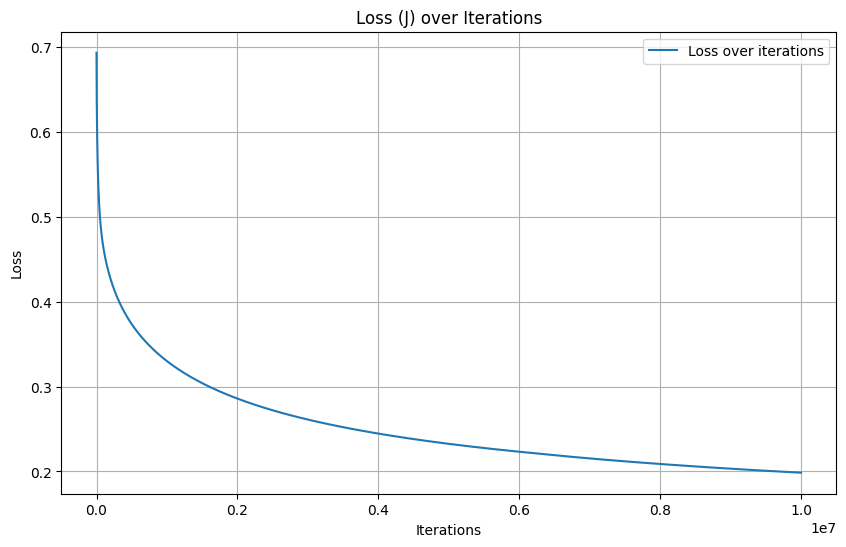

In [266]:
plt.figure(figsize=(10, 6))
plt.plot(J, label="Loss over iterations")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss (J) over Iterations")
plt.legend()
plt.grid(True)
plt.show()

### Inference

In [267]:
y_hat = predict(X_test_scaled, theta)

/var/folders/rj/bvrtrtcd4qxgkzx7v4rk09m40000gn/T/ipykernel_11616/1630184811.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


### Eval

#### Accuracy

In [268]:
accuracy = compute_accuracy(y_hat, y_test)
print(f"Model accuracy: {accuracy * 100:.2f}%")

Model accuracy: 95.36%


#### Confusion matrix

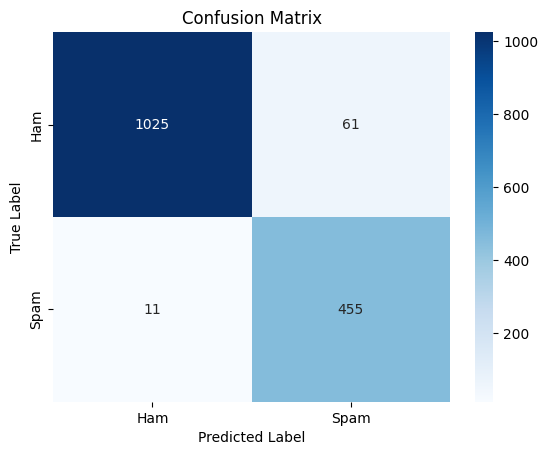

In [269]:
cm = confusion_matrix(y_true=y_test, y_pred=y_hat)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Ham", "Spam"],
    yticklabels=["Ham", "Spam"],  #
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#### Comment about confusion matrix

True Negatives (TN): The upper left cell shows the number 355, which indicates that there are 355 instances where the model correctly predicted "Ham".

False Positives (FP): The upper right cell indicates 20, which means there are 20 instances where the model incorrectly predicted "Spam" when the true label was "Ham".

False Negatives (FN): The lower left cell has the number 3, suggesting that there are 3 instances where the model incorrectly predicted "Ham" when the true label was "Spam".

True Positives (TP): The lower right cell shows 140, indicating there are 140 instances where the model correctly predicted "Spam".

#### Observing errornouss predictions

In [270]:
fp_indices = np.where((y_hat == 1) & (y_test == 0))[0]
fn_indices = np.where((y_hat == 0) & (y_test == 1))[0]

fp_samples = X_test[fp_indices]
fn_samples = X_test[fn_indices]

fp_emails = emails_test[fp_indices]
fn_emails = emails_test[fn_indices]

print("False positives")
print("-----------------------")
for i, email in enumerate(fp_emails):
    print(f"{i}. {email}")
    print("-----------------------")

print("False negatives")
print("-----------------------")
for i, email in enumerate(fn_emails):
    print(f"{i}. {email}")
    print("-----------------------")

False positives
-----------------------
0. Subject: hoston hoop - it - up 6 weeks away !
dear daren :
did you mark on your sporting event calendar to be in houston on may 5 th - 6 th at greenspoint mall for the largest 3 - on - 3 basketball action in the country ? with less than 6 weeks until the entry deadline of april 25 th , the hoop - it - up staff is gearing up and coming to town !
you should have received your entry form if you have played in the houston event in the past but if not , please contact our local hotline at 713 - 521 - 4535 and our representative will take care of you right away . you can also visit any houston - area foot locker or army recruiting station to pick up an entry form right there on the spot . if you ' d like to enter even faster , register online at www . hoopitup . com and waste no time at all getting in on the action .
again , don ' t get left out of the game . . . call our hotline at 713 - 521 - 4535 for more information or log on to our website at w

/var/folders/rj/bvrtrtcd4qxgkzx7v4rk09m40000gn/T/ipykernel_11616/1630184811.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


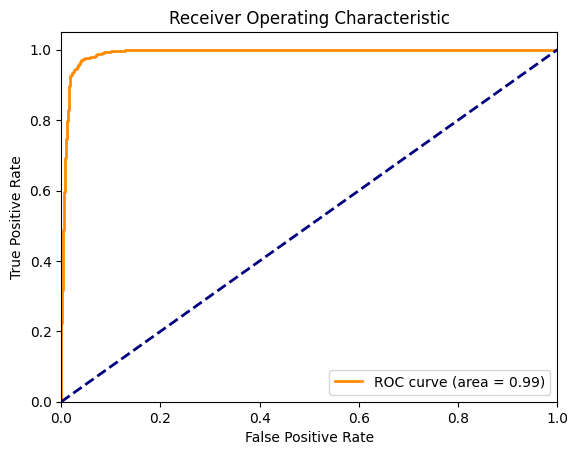

In [271]:
y_hat_probas = predict(X_test_scaled, theta, probas=True)
fpr, tpr, _ = roc_curve(y_test, y_hat_probas)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

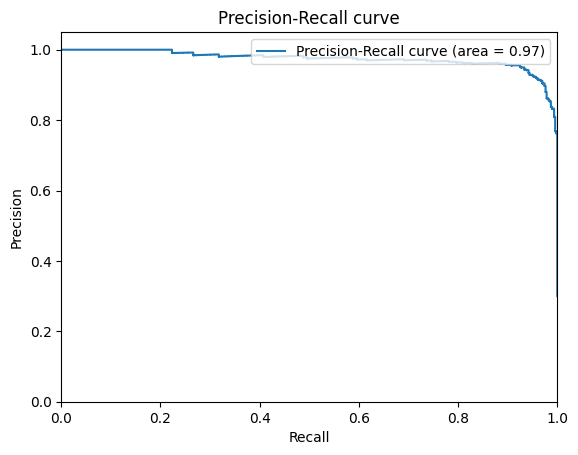

In [272]:
precision, recall, _ = precision_recall_curve(y_test, y_hat_probas)
average_precision = average_precision_score(y_test, y_hat_probas)

plt.figure()
plt.step(
    recall,
    precision,
    where="post",
    label="Precision-Recall curve (area = %0.2f)" % average_precision,
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curve")
plt.legend(loc="upper right")
plt.show()